# analytical method for correction of AuNRs 

In [4]:
import sys
# add path for my packages
sys.path.append('C:\\Users\\katsuya2\\OneDrive - University of Illinois - Urbana\\Documents\\Python Scripts\\my_packages')
import re
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import ast
import seaborn as sns
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.stats import norm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from pathlib import Path
from glob import glob
%precision 3
%matplotlib inline

# use my matplotlib style
style_p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/my_packages")
plt.style.use(Path(style_p, 'my_rc_setting.mplstyle'))

import Lorentzian

## upload dataset

In [5]:
p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/input_data/SPP2023")

# all glass data
glass_data = pd.read_csv(Path(p, '090723_glass_training.csv'))
glass_data['ratio'] = glass_data['length'] / glass_data['width']
glass_data = glass_data.drop(['corrcoef'], axis=1)
glass_data['volume'] = np.pi*(glass_data['width']**2)*glass_data['length']/4 - np.pi*(glass_data['width']**3)/12

# all ITO data
ito_data = pd.read_csv(Path(p, '111623_ito_training.csv'))
ito_data['ratio'] = ito_data['length'] / ito_data['width']
ito_data = ito_data.drop(['corrcoef'], axis=1)

# further control the dataset so that all aspect ratio in glass can fall into the range of ITO's ratio
ito_ratio_min = ito_data['ratio'].min()
ito_ratio_max = ito_data['ratio'].max()

glass_data = glass_data[(glass_data['ratio'] > ito_ratio_min) & (glass_data['ratio'] < ito_ratio_max)]
glass_data = glass_data.reset_index(drop=True)
print(glass_data.shape)

# further control the dataset so that all width and length in glass can fal into the range of ITO's
ito_width_min = ito_data['width'].min()
ito_width_max = ito_data['width'].max()
ito_length_min = ito_data['length'].min()
ito_length_max = ito_data['length'].max()

glass_data = glass_data[(glass_data['width'] > ito_width_min) & (glass_data['width'] < ito_width_max)]
glass_data = glass_data[(glass_data['length'] > ito_length_min) & (glass_data['length'] < ito_length_max)]
glass_data = glass_data.reset_index(drop=True)
print(glass_data.shape)

# Randomly sample 1000 rows from each dataframe
glass_data = glass_data.sample(n=1000, random_state=42)
glass_data = glass_data.reset_index(drop=True)
ito_data = ito_data.sample(n=1000, random_state=42)
ito_data = ito_data.reset_index(drop=True)
print(glass_data.shape)

(1205, 7)
(1179, 7)
(1000, 7)


## latest analytical method as of 060424

In [16]:
def analytical_method(glass_data, target_n):
    l_d = 0.37 * glass_data['volume']**(1/3)
    term1 = (glass_data['width'] + l_d) / (glass_data['width'] + 2*l_d)
    # term2 = l_d / (glass_data['width'] + 2*l_d)
    
    # Constants
    omega_p = 9  # plasma frequency in eV
    epsilon_inf = 9.84  # high-frequency dielectric constant
    n_glass = 1.52  # effective refractive index for glass substrate
    aspect_ratio = glass_data['ratio']  # given aspect ratio
    n_X = target_n  # refractive index for unknown substrate

    alpha = term1
    n_med = 1.0
    n_eff_glass = alpha*n_med + n_glass*(1-alpha)
    n_eff_X = alpha*n_med + n_X*(1-alpha)

    # Depolarization factor L for the given aspect ratio
    L = (1 + aspect_ratio)**-1.6

    # Resonance energy for glass substrate
    E_res_glass = omega_p / np.sqrt(n_eff_glass**2 / L + epsilon_inf - n_eff_glass**2)

    # Resonance energy for unknown substrate
    E_res_X = omega_p / np.sqrt(n_eff_X**2 / L + epsilon_inf - n_eff_X**2)

    # Calculate the factor F
    F = E_res_X / E_res_glass
    
    return F

In [17]:
F_Al2O3 = analytical_method(glass_data, target_n=1.762)
F_ITO = analytical_method(glass_data, target_n=1.975)
F_TiO2 = analytical_method(glass_data, target_n=2.358)

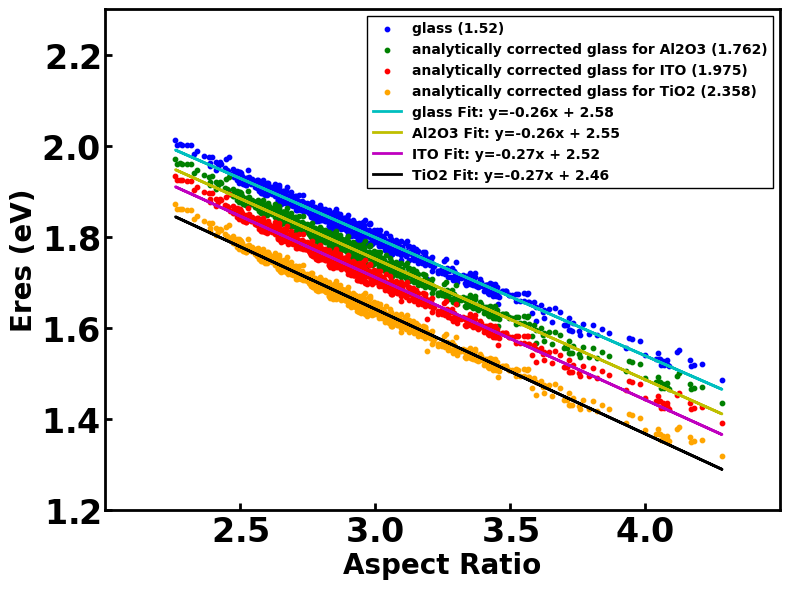

In [18]:
# Eres vs AR ITO and glass
plt.scatter(glass_data['ratio'], glass_data['eres'], s=10, c='b', label='glass (1.52)')
plt.scatter(glass_data['ratio'], glass_data['eres']*F_Al2O3, c='g', s=10, label='analytically corrected glass for Al2O3 (1.762)')
plt.scatter(glass_data['ratio'], glass_data['eres']*F_ITO, s=10, c='r', label='analytically corrected glass for ITO (1.975)')
plt.scatter(glass_data['ratio'], glass_data['eres']*F_TiO2, s=10, c='orange', label='analytically corrected glass for TiO2 (2.358)')

# Perform linear regression
model_glass = LinearRegression()
model_glass.fit(glass_data['ratio'].values.reshape(-1, 1), glass_data['eres'])
slope_glass, intercept_glass = model_glass.coef_[0], model_glass.intercept_
plt.plot(glass_data['ratio'], slope_glass * glass_data['ratio'] + intercept_glass, c='c', lw=2, label=f'glass Fit: y={slope_glass:.2f}x + {intercept_glass:.2f}')

model_Al2O3 = LinearRegression()
model_Al2O3.fit(glass_data['ratio'].values.reshape(-1, 1), glass_data['eres']*F_Al2O3)
slope_Al2O3, intercept_Al2O3 = model_Al2O3.coef_[0], model_Al2O3.intercept_
plt.plot(glass_data['ratio'], slope_Al2O3 * glass_data['ratio'] + intercept_Al2O3, c='y', lw=2, label=f'Al2O3 Fit: y={slope_Al2O3:.2f}x + {intercept_Al2O3:.2f}')

model_ITO = LinearRegression()
model_ITO.fit(glass_data['ratio'].values.reshape(-1, 1), glass_data['eres']*F_ITO)
slope_ITO, intercept_ITO = model_ITO.coef_[0], model_ITO.intercept_
plt.plot(glass_data['ratio'], slope_ITO * glass_data['ratio'] + intercept_ITO, c='m', lw=2, label=f'ITO Fit: y={slope_ITO:.2f}x + {intercept_ITO:.2f}')

model_TiO2 = LinearRegression()
model_TiO2.fit(glass_data['ratio'].values.reshape(-1, 1), glass_data['eres']*F_TiO2)
slope_TiO2, intercept_TiO2 = model_TiO2.coef_[0], model_TiO2.intercept_
plt.plot(glass_data['ratio'], slope_TiO2 * glass_data['ratio'] + intercept_TiO2, c='k', lw=2, label=f'TiO2 Fit: y={slope_TiO2:.2f}x + {intercept_TiO2:.2f}')

plt.xlabel('Aspect Ratio')
plt.ylabel('Eres (eV)')
plt.xticks([2.5, 3.0, 3.5, 4.0])
plt.xlim(2, 4.5)
plt.ylim(1.2, 2.3)
plt.legend()

# numerical method for correction of AuNRs 

In [19]:
def calc_dif(idx, ito_data, glass_data):
    Eres_glass = glass_data['eres'][idx]
    Linewidth_glass = glass_data['linewidth'][idx]
    AR_glass = glass_data['ratio'][idx]

    upper_min = ito_data[ito_data['ratio'] > AR_glass]['ratio'].min()
    lower_max = ito_data[ito_data['ratio'] < AR_glass]['ratio'].max()

    if abs(upper_min - AR_glass) > abs(lower_max - AR_glass):
        AR_ito_closest = lower_max
    else:
        AR_ito_closest = upper_min

    Eres_ito = ito_data[ito_data['ratio'] == AR_ito_closest]['eres']
    Linewidth_ito = ito_data[ito_data['ratio'] == AR_ito_closest]['linewidth']
    dEres_IG = Eres_ito - Eres_glass
    dLinewidth_IG = Linewidth_ito - Linewidth_glass
    return dEres_IG, dLinewidth_IG


def calculate_mean(lst):
    return sum(lst) / len(lst)


def numerical_method(ito_data, glass_data, target_nsub):
    ito_nsub = 1.975
    glass_nsub = 1.52
    dnsub_IG = ito_nsub - glass_nsub
    dEres_IG_list = []
    dLinewidth_IG_list = []
    for idx in range(glass_data.shape[0]):
        dEres_IG, dLinewidth_IG = calc_dif(idx, ito_data, glass_data)
        if (dEres_IG.shape == (1,)) and (dLinewidth_IG.shape == (1,)): 
            dEres_IG_list.append(dEres_IG.values)
            dLinewidth_IG_list.append(dLinewidth_IG.values)

    dEres_IG_mean = calculate_mean(dEres_IG_list)
    dLinewidth_IG_mean = calculate_mean(dLinewidth_IG_list)
    C = dEres_IG_mean / dnsub_IG
    D = dLinewidth_IG_mean / dnsub_IG
    target_Eres = C*(target_nsub - glass_nsub) + glass_data['eres']
    target_Linewidth = D*(target_nsub - glass_nsub) + glass_data['linewidth']
    return target_Eres, target_Linewidth

In [20]:
Al2O3_nsub = 1.762
ITO_nsub = 1.975
TiO2_nsub = 2.358
Al2O3_Eres, Al2O3_Linewidth = numerical_method(ito_data, glass_data, target_nsub=Al2O3_nsub)
ITO_Eres, ITO_Linewidth = numerical_method(ito_data, glass_data, target_nsub=ITO_nsub)
TiO2_Eres, TiO2_Linewidth = numerical_method(ito_data, glass_data, target_nsub=TiO2_nsub)

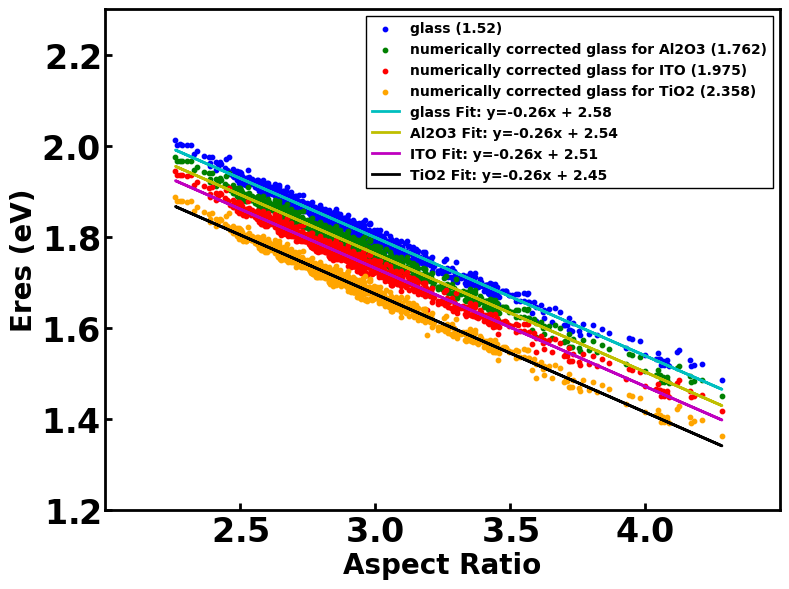

In [21]:
plt.scatter(glass_data['ratio'], glass_data['eres'], s=10, c='b', label='glass (1.52)')
plt.scatter(glass_data['ratio'], Al2O3_Eres, s=10, c='g', label='numerically corrected glass for Al2O3 (1.762)')
plt.scatter(glass_data['ratio'], ITO_Eres, s=10, c='r', label='numerically corrected glass for ITO (1.975)')
plt.scatter(glass_data['ratio'], TiO2_Eres, s=10, c='orange', label='numerically corrected glass for TiO2 (2.358)')

# Perform linear regression
model_glass = LinearRegression()
model_glass.fit(glass_data['ratio'].values.reshape(-1, 1), glass_data['eres'])
slope_glass, intercept_glass = model_glass.coef_[0], model_glass.intercept_
plt.plot(glass_data['ratio'], slope_glass * glass_data['ratio'] + intercept_glass, c='c', lw=2, label=f'glass Fit: y={slope_glass:.2f}x + {intercept_glass:.2f}')

model_Al2O3 = LinearRegression()
model_Al2O3.fit(glass_data['ratio'].values.reshape(-1, 1), Al2O3_Eres)
slope_Al2O3, intercept_Al2O3 = model_Al2O3.coef_[0], model_Al2O3.intercept_
plt.plot(glass_data['ratio'], slope_Al2O3 * glass_data['ratio'] + intercept_Al2O3, c='y', lw=2, label=f'Al2O3 Fit: y={slope_Al2O3:.2f}x + {intercept_Al2O3:.2f}')

model_ITO = LinearRegression()
model_ITO.fit(glass_data['ratio'].values.reshape(-1, 1), ITO_Eres)
slope_ITO, intercept_ITO = model_ITO.coef_[0], model_ITO.intercept_
plt.plot(glass_data['ratio'], slope_ITO * glass_data['ratio'] + intercept_ITO, c='m', lw=2, label=f'ITO Fit: y={slope_ITO:.2f}x + {intercept_ITO:.2f}')

model_TiO2 = LinearRegression()
model_TiO2.fit(glass_data['ratio'].values.reshape(-1, 1), TiO2_Eres)
slope_TiO2, intercept_TiO2 = model_TiO2.coef_[0], model_TiO2.intercept_
plt.plot(glass_data['ratio'], slope_TiO2 * glass_data['ratio'] + intercept_TiO2, c='k', lw=2, label=f'TiO2 Fit: y={slope_TiO2:.2f}x + {intercept_TiO2:.2f}')

plt.xlabel('Aspect Ratio')
plt.ylabel('Eres (eV)')
plt.xticks([2.5, 3.0, 3.5, 4.0])
plt.xlim(2, 4.5)
plt.ylim(1.2, 2.3)
plt.legend()

# Linewidth

In [86]:
# why not correction on linewidth? 
# If it's not as dominant as eres changes, how much dominant eres could be?
# only numerical method

F_ITO = analytical_method(glass_data, target_n=1.96)
F_TiO2 = analytical_method(glass_data, target_n=2.36)

ITO_nsub = 1.96
TiO2_nsub = 2.36
ITO_Eres, ITO_Linewidth = numerical_method(ito_data, glass_data, target_nsub=ITO_nsub)
TiO2_Eres, TiO2_Linewidth = numerical_method(ito_data, glass_data, target_nsub=TiO2_nsub)

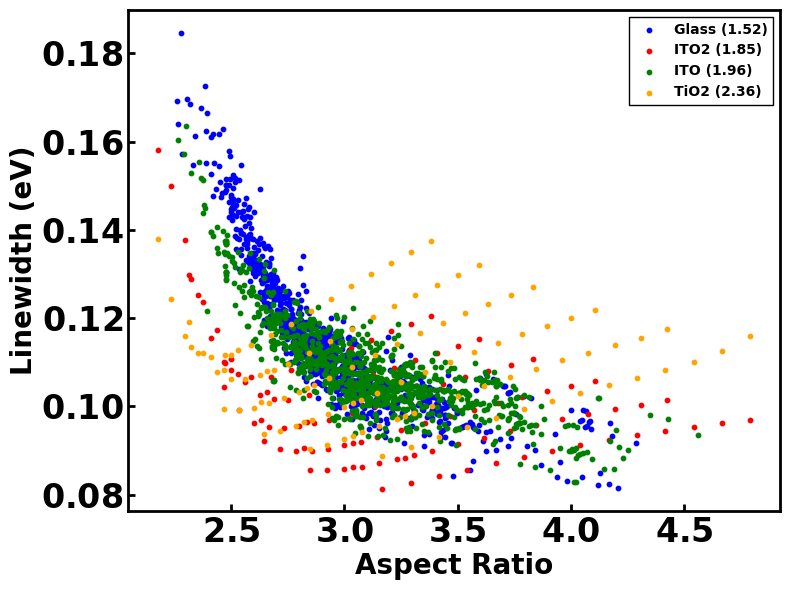

In [91]:
plt.scatter(glass_data['ratio'], glass_data['linewidth'], s=10, c='b', label='Glass (1.52)')
# plt.scatter(glass_data['ratio'], glass_data['linewidth']*F_ITO, s=10, c='g', label='Analytically corrected ITO (1.96)')
# plt.scatter(ito_data['ratio'], ITO_Linewidth, s=10, c='orange', label='Numerically corrected ITO (1.96)')

plt.scatter(ito_data2['ratio'], ito_data2['linewidth'], s=10, c='r', label='ITO2 (1.85)')
plt.scatter(ito_data['ratio'], ito_data['linewidth'], s=10, c='g', label='ITO (1.96)')
plt.scatter(tio2_data['ratio'], tio2_data['linewidth'], s=10, c='orange', label='TiO2 (2.36)')

plt.xlabel('Aspect Ratio')
plt.ylabel('Linewidth (eV)')
plt.legend()

# Comparisons

In [4]:
# We have simulated TiO2 and ITO (n=1.85).
# Test which is better correciton method, analytical and numerical

In [70]:
p_data = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/projects/AuNR_DA/datasets")

tio2_data = pd.read_csv(Path(p_data, '040424_tio2_data.csv'))
tio2_data['ratio'] = tio2_data['length'] / tio2_data['width']

ito_data2 = pd.read_csv(Path(p_data, '040524_ito_data.csv'))
ito_data2['ratio'] = ito_data2['length'] / ito_data2['width']
print(tio2_data.shape, ito_data2.shape)

(303, 7) (302, 7)


In [71]:
print(tio2_data.shape)
tio2_data = tio2_data[(tio2_data['width'] > ito_data['width'].min()) & (tio2_data['width'] < ito_data['width'].max()) 
                       & (tio2_data['length'] > ito_data['length'].min()) & (tio2_data['length'] < ito_data['length'].max())]

tio2_data = tio2_data.reset_index(drop=True)
print(tio2_data.shape)


print(ito_data2.shape)
ito_data2 = ito_data2[(ito_data2['width'] > ito_data['width'].min()) & (ito_data2['width'] < ito_data['width'].max()) 
                       & (ito_data2['length'] > ito_data['length'].min()) & (ito_data2['length'] < ito_data['length'].max())]

ito_data2 = ito_data2.reset_index(drop=True)
print(ito_data2.shape)

(303, 7)
(109, 7)
(302, 7)
(109, 7)


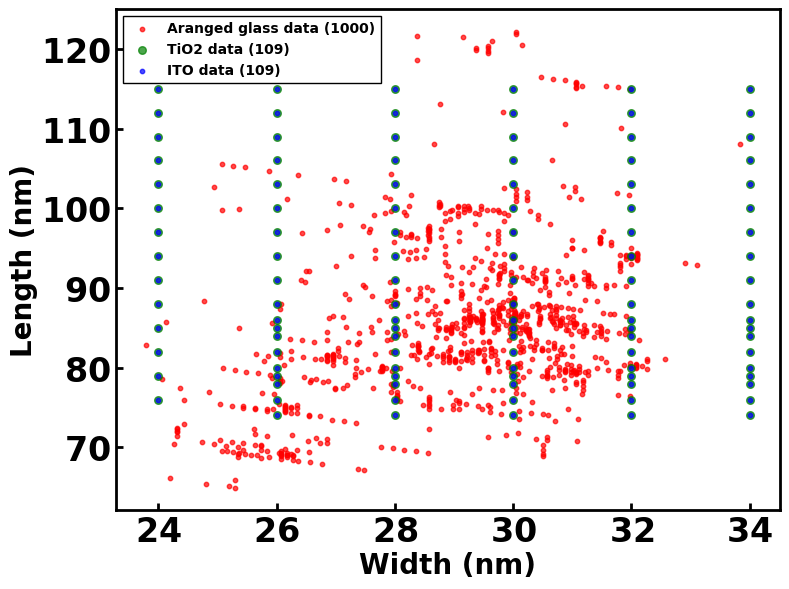

In [80]:
# size distributions
fig, ax = plt.subplots()

ax.scatter(glass_data['width'], glass_data['length'], c='r', s=10, alpha=.7, label=f'Aranged glass data ({glass_data.shape[0]})')
ax.scatter(tio2_data['width'], tio2_data['length'], c='g', s=30, alpha=.7, label=f'TiO2 data ({tio2_data.shape[0]})')
ax.scatter(ito_data2['width'], ito_data2['length'], c='b', s=10, alpha=.7, label=f'ITO data ({ito_data2.shape[0]})')

ax.set_xlabel('Width (nm)')
ax.set_ylabel('Length (nm)')
ax.legend()

# ax.set_xlim(15, 50)
# ax.set_ylim(50, 130)

In [43]:
F_ITO = analytical_method(glass_data, target_n=1.85)
F_TiO2 = analytical_method(glass_data, target_n=2.36)

In [44]:
ITO_nsub = 1.85
TiO2_nsub = 2.36
ITO_Eres, ITO_Linewidth = numerical_method(ito_data, glass_data, target_nsub=ITO_nsub)
TiO2_Eres, TiO2_Linewidth = numerical_method(ito_data, glass_data, target_nsub=TiO2_nsub)

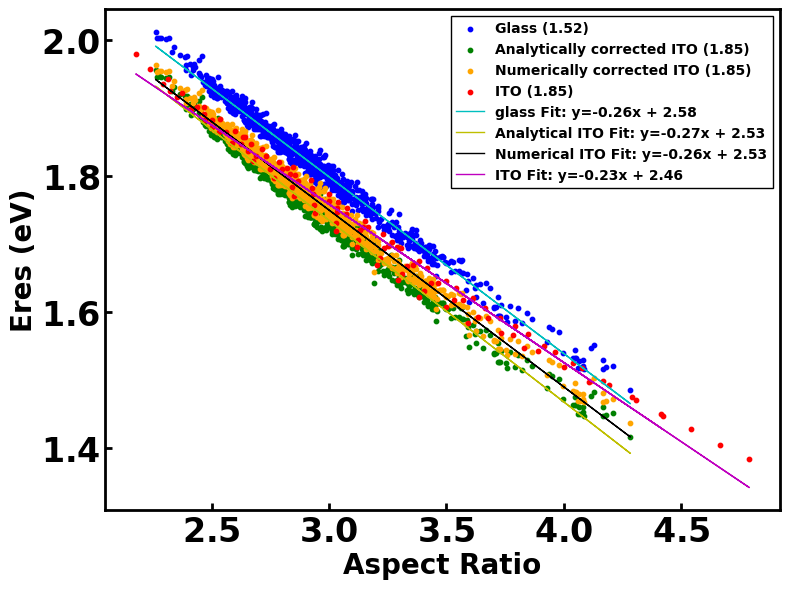

In [59]:
plt.scatter(glass_data['ratio'], glass_data['eres'], s=10, c='b', label='Glass (1.52)')
plt.scatter(glass_data['ratio'], glass_data['eres']*F_ITO, s=10, c='g', label='Analytically corrected ITO (1.85)')
plt.scatter(glass_data['ratio'], ITO_Eres, s=10, c='orange', label='Numerically corrected ITO (1.85)')
plt.scatter(ito_data2['ratio'], ito_data2['eres'], s=10, c='r', label='ITO (1.85)')

# Perform linear regression
model_glass = LinearRegression()
model_glass.fit(glass_data['ratio'].values.reshape(-1, 1), glass_data['eres'])
slope_glass, intercept_glass = model_glass.coef_[0], model_glass.intercept_
plt.plot(glass_data['ratio'], slope_glass * glass_data['ratio'] + intercept_glass, c='c', lw=1, label=f'glass Fit: y={slope_glass:.2f}x + {intercept_glass:.2f}')

model_ITO = LinearRegression()
model_ITO.fit(glass_data['ratio'].values.reshape(-1, 1), glass_data['eres']*F_ITO)
slope_ITO, intercept_ITO = model_ITO.coef_[0], model_ITO.intercept_
plt.plot(glass_data['ratio'], slope_ITO * glass_data['ratio'] + intercept_ITO, c='y', lw=1, label=f'Analytical ITO Fit: y={slope_ITO:.2f}x + {intercept_ITO:.2f}')

model_ITO1 = LinearRegression()
model_ITO1.fit(glass_data['ratio'].values.reshape(-1, 1), ITO_Eres)
slope_ITO1, intercept_ITO1 = model_ITO1.coef_[0], model_ITO1.intercept_
plt.plot(glass_data['ratio'], slope_ITO1 * glass_data['ratio'] + intercept_ITO1, c='k', lw=1, label=f'Numerical ITO Fit: y={slope_ITO1:.2f}x + {intercept_ITO1:.2f}')

model_ITO2 = LinearRegression()
model_ITO2.fit(ito_data2['ratio'].values.reshape(-1, 1), ito_data2['eres'])
slope_ITO2, intercept_ITO2 = model_ITO2.coef_[0], model_ITO2.intercept_
plt.plot(ito_data2['ratio'], slope_ITO2 * ito_data2['ratio'] + intercept_ITO2, c='m', lw=1, label=f'ITO Fit: y={slope_ITO2:.2f}x + {intercept_ITO2:.2f}')

plt.xlabel('Aspect Ratio')
plt.ylabel('Eres (eV)')
plt.legend()

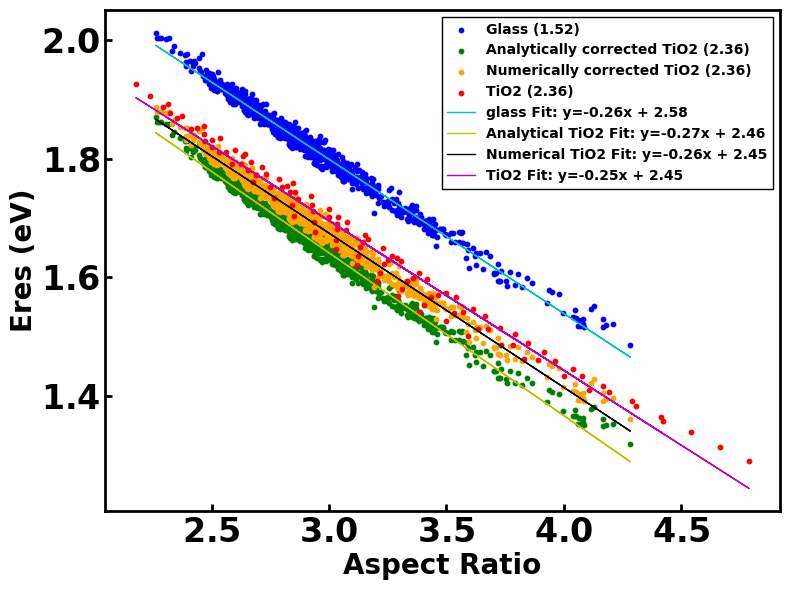

In [63]:
plt.scatter(glass_data['ratio'], glass_data['eres'], s=10, c='b', label='Glass (1.52)')
plt.scatter(glass_data['ratio'], glass_data['eres']*F_TiO2, s=10, c='g', label='Analytically corrected TiO2 (2.36)')
plt.scatter(glass_data['ratio'], TiO2_Eres, s=10, c='orange', label='Numerically corrected TiO2 (2.36)')
plt.scatter(tio2_data['ratio'], tio2_data['eres'], s=10, c='r', label='TiO2 (2.36)')

# Perform linear regression
model_glass = LinearRegression()
model_glass.fit(glass_data['ratio'].values.reshape(-1, 1), glass_data['eres'])
slope_glass, intercept_glass = model_glass.coef_[0], model_glass.intercept_
plt.plot(glass_data['ratio'], slope_glass * glass_data['ratio'] + intercept_glass, c='c', lw=1, label=f'glass Fit: y={slope_glass:.2f}x + {intercept_glass:.2f}')

model_TiO2 = LinearRegression()
model_TiO2.fit(glass_data['ratio'].values.reshape(-1, 1), glass_data['eres']*F_TiO2)
slope_TiO2, intercept_TiO2 = model_TiO2.coef_[0], model_TiO2.intercept_
plt.plot(glass_data['ratio'], slope_TiO2 * glass_data['ratio'] + intercept_TiO2, c='y', lw=1, label=f'Analytical TiO2 Fit: y={slope_TiO2:.2f}x + {intercept_TiO2:.2f}')

model_TiO21 = LinearRegression()
model_TiO21.fit(glass_data['ratio'].values.reshape(-1, 1), TiO2_Eres)
slope_TiO21, intercept_TiO21 = model_TiO21.coef_[0], model_TiO21.intercept_
plt.plot(glass_data['ratio'], slope_TiO21 * glass_data['ratio'] + intercept_TiO21, c='k', lw=1, label=f'Numerical TiO2 Fit: y={slope_TiO21:.2f}x + {intercept_TiO21:.2f}')

model_TiO22 = LinearRegression()
model_TiO22.fit(tio2_data['ratio'].values.reshape(-1, 1), tio2_data['eres'])
slope_TiO22, intercept_TiO22 = model_TiO22.coef_[0], model_TiO22.intercept_
plt.plot(tio2_data['ratio'], slope_TiO22 * ito_data2['ratio'] + intercept_TiO22, c='m', lw=1, label=f'TiO2 Fit: y={slope_TiO22:.2f}x + {intercept_TiO22:.2f}')


plt.xlabel('Aspect Ratio')
plt.ylabel('Eres (eV)')
plt.legend()

## Other mapping methods

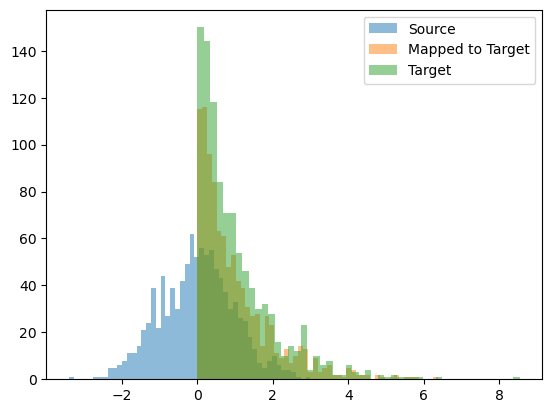

In [1]:
import numpy as np
from scipy.stats import norm

# Generate sample data
source_data = np.random.normal(0, 1, 1000)  # Source distribution: Normal(0, 1)
target_data = np.random.exponential(1, 1000)  # Target distribution: Exponential(1)

# Compute the empirical CDFs
source_cdf = np.argsort(np.argsort(source_data)) / len(source_data)
target_sorted = np.sort(target_data)
target_cdf = np.linspace(0, 1, len(target_data))

# Map the source data to the target distribution
mapped_data = np.interp(source_cdf, target_cdf, target_sorted)

# Verify the transformation
import matplotlib.pyplot as plt
plt.hist(source_data, bins=50, alpha=0.5, label='Source')
plt.hist(mapped_data, bins=50, alpha=0.5, label='Mapped to Target')
plt.hist(target_data, bins=50, alpha=0.5, label='Target')
plt.legend()
plt.show()


In [13]:
%pip install pot

  Obtaining dependency information for pot from https://files.pythonhosted.org/packages/38/b2/ff69499ec57505d2a98362bae2659f5f5152a1137448176c691241d67816/POT-0.9.4-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/309.1 kB ? eta -:--:--
   ----------- ---------------------------- 92.2/309.1 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 309.1/309.1 kB 3.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [21]:
glass_data[['ratio', 'eres']].to_numpy()

array([[2.726, 1.875],
       [3.031, 1.786],
       [2.775, 1.861],
       ...,
       [2.913, 1.815],
       [2.932, 1.809],
       [2.765, 1.86 ]])

In [29]:
x1.shape
x2.shape

(1000, 2)

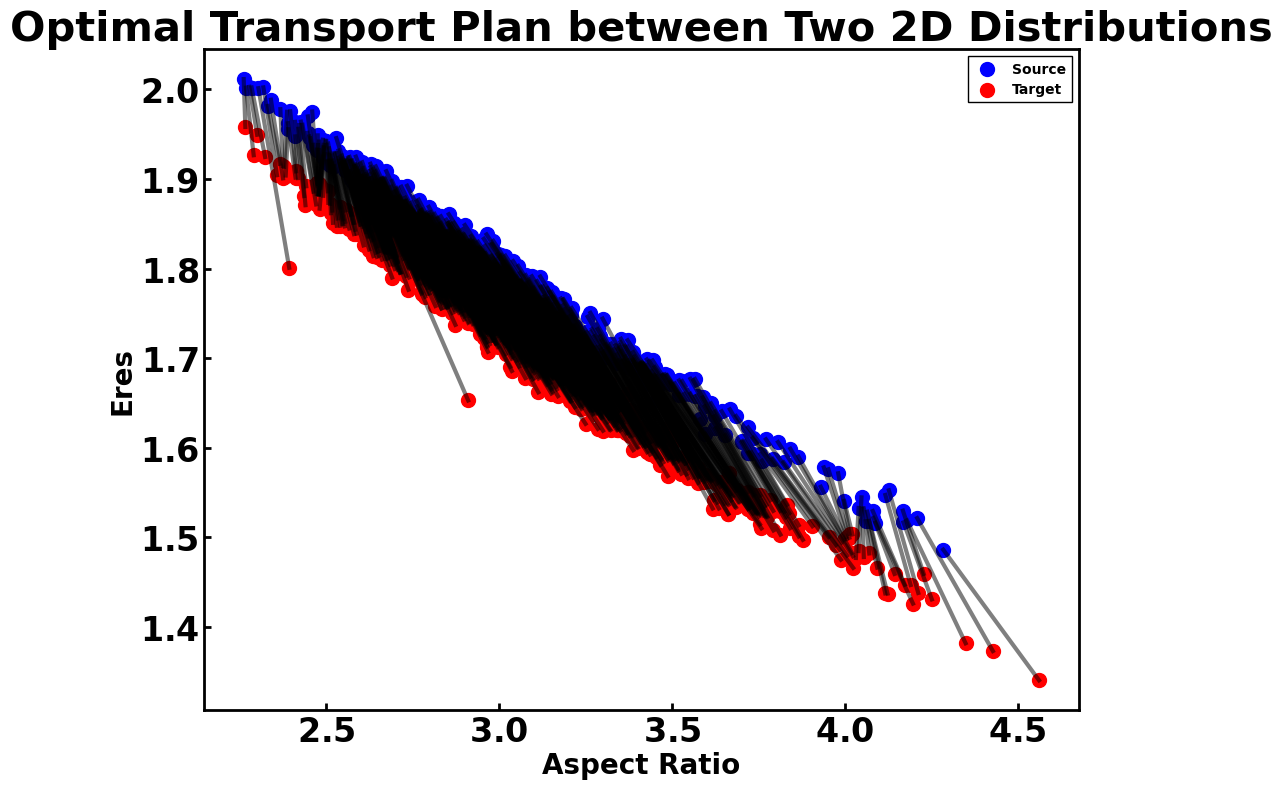

In [32]:
import numpy as np
import ot
import matplotlib.pyplot as plt

# Generate sample data for two 2D distributions
n_samples = 1000
# mu1 = np.array([1, 1])
# cov1 = np.array([[1, 0.5], [0.5, 1]])
# x1 = np.random.multivariate_normal(mu1, cov1, n_samples)

# mu2 = np.array([4, 4])
# cov2 = np.array([[1, -0.3], [-0.3, 1]])
# x2 = np.random.multivariate_normal(mu2, cov2, n_samples)

x1 = glass_data[['ratio', 'eres']].to_numpy()
x2 = ito_data[['ratio', 'eres']].to_numpy()

# Compute the cost matrix
M = ot.dist(x1, x2, metric='euclidean')

# Uniform distributions on samples
a = np.ones((n_samples,)) / n_samples
b = np.ones((n_samples,)) / n_samples

# Solve optimal transport problem
G = ot.emd(a, b, M)

# Plot the distributions and the transport plan
plt.figure(figsize=(10, 8))
plt.scatter(x1[:, 0], x1[:, 1], c='blue', label='Source')
plt.scatter(x2[:, 0], x2[:, 1], c='red', label='Target')

# Plot the transport plan
for i in range(n_samples):
    for j in range(n_samples):
        if G[i, j] > 1e-8:  # Only plot significant transport links
            plt.plot([x1[i, 0], x2[j, 0]], [x1[i, 1], x2[j, 1]], 'k-', alpha=0.5)

plt.legend()
plt.title('Optimal Transport Plan between Two 2D Distributions')
plt.xlabel('Aspect Ratio')
plt.ylabel('Eres')
plt.show()
